In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT
from ATARI.syndat.control import Syndat_Control

from ATARI.AutoFit import chi2_eliminator_v2
from ATARI.AutoFit import elim_addit_funcs


In [2]:
%matplotlib widget

## AutoFit User Example

This notebook gives an examle how the ATARI.AutoFit module can be used to automatically fit data with no need for a prior.

In [3]:
# plotting data & fits
# default fig size to output
fig_size = (8,6)
dpi=75

# if we will save images - where to save
savefolder = 'all_data_temp/'
if not os.path.exists(savefolder):
    # If it doesn't exist, create it
    os.makedirs(savefolder)

def plot_datafits(datasets, experiments, 
    fits=[], fits_chi2=[], f_model_name='fit',
    priors=[], priors_chi2=[], pr_model_name='prior',
    true=[], true_chi2=[], t_model_name ='true',
    true_pars = pd.DataFrame(), 
    prior_pars = pd.DataFrame(),
    fit_pars = pd.DataFrame(),
    title: str = '',
    show_spingroups: bool = True,
    fig_size : tuple = (8,6)
    ):

    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=fig_size, sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color='black', alpha=0.5, linewidth=1.0, markersize=4, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            if (len(fits_chi2) != 0):
                fit_label = f'{f_model_name} {exp.title} ({fits_chi2[i]})'
            else:
                fit_label = f'{f_model_name} {exp.title}'
            axes[iax].plot(fits[i].E, fits[i][model_key], color='red', zorder=1, lw=1.5, label=fit_label) # colors[i]
        
        if len(priors) != 0:
            if (len(priors_chi2) != 0):
                prior_label = f'{pr_model_name} {exp.title} ({priors_chi2[i]})'
            else:
                prior_label = f'{pr_model_name} {exp.title}'

            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color='orange', zorder=0, lw=1.5, label=prior_label)
        
        if len(true) != 0:
            if (len(true_chi2) != 0):
                true_label = f'{t_model_name} {exp.title} ({true_chi2[i]})'
            else:
                true_label = f'{t_model_name} {exp.title}'
            axes[iax].plot(true[i].E, true[i]['true'], '-', color='green', zorder=1, alpha=0.5, lw=1.5, label=true_label)


    # Set the y-axis limits with additional space for text and capture ymax before changing
    
    y_top_padding = 0.1 
    x_offset = 0.05

    ymax_values = [ax.get_ylim()[1] for ax in axes]  # Store original ymax values for each axis
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + y_top_padding)

    font_size = 8
    y_text_shift = 0.01  # Adjust as needed, related to font size
    y_text_positions = [ymax_values[0], ymax_values[1]]

    # show vertical lines for energies
    
    # fits
    for index, res in fit_pars.iterrows():
        res_E = res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
        axes[1].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(int(res.J_ID),0)
            
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = res_E + x_offset
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                #ax.text(x_text_position, y_text_position, str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=8)

                ax.text(res_E, y_text_positions[i], str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=font_size)
                y_text_positions[i] -= y_text_shift


    # the same for theoretical positions
    for index, true_res in true_pars.iterrows():

        true_res_energy = true_res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)
        axes[1].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(true_res.J_ID,0)
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = true_res_energy
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                ax.text(x_text_position , y_text_position, str(sp_gr_txt), color='g', verticalalignment='bottom', fontsize=8)

    
    for index, res in prior_pars.iterrows():
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)
        axes[1].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    # set title
    fig.suptitle(title, fontsize=14)
    
    # additional info if present
    add_title = ''
    if (true_pars.shape[0]>0):
        add_title+=''+r'$N_{true}$ = '+str(true_pars.shape[0])
        
    if (len(true_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(true_chi2),3))

    if (prior_pars.shape[0]>0):
        add_title+=', '+r'$N_{prior}$ = '+str(prior_pars.shape[0])
    if (len(priors_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(priors_chi2),3))

    if (fit_pars.shape[0]>0):
        add_title+=', '+r'$N_{fit}$ = '+str(fit_pars.shape[0])
    if (len(fits_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(fits_chi2),3))
    
    # end additional info if present
    axes[0].set_title(add_title, fontsize=10)
    

    # ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        # ax.set_ylim([-0.1,1.1])
        ax.legend(fontsize='small', loc='lower right')

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

## First, generate data with Syndat to play with

In [4]:
### Reaction Model
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,250],
                        ac = 8.127,
                        M = 180.94803,
                        I = 3,
                        l_max = 2
)

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

### Experimental Models
cap1mm_exp_gen = Experimental_Model(title = "cap1",
                                reaction ="capture", 
                                energy_range = [200, 250],
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )

trans1mm_exp_gen = Experimental_Model(title = "trans1",
                               reaction = "transmission", 
                               energy_range = [200,250],
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),
                               channel_widths={
                                    "maxE": [216.16, 613.02], 
                                    "chw": [204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                }
                               )

sammy_rto = sammy_classes.SammyRunTimeOptions('/home/fire/SAMMY/sammy/build/install/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })

template_creator.make_input_template('template_T.inp', Ta_pair, trans1mm_exp_gen, sammy_rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, cap1mm_exp_gen, sammy_rto)

cap1mm_exp_gen.template = os.path.realpath('template_Y.inp')
trans1mm_exp_gen.template = os.path.realpath('template_T.inp')

### Measurement Models
cap1mm_meas_gen = Capture_Yield_RPI()
cap1mm_meas_red = Capture_Yield_RPI()

trans1mm_meas_gen = Transmission_RPI()
trans1mm_meas_red = Transmission_RPI()


### Syndat Models
options_cap1mm = syndatOPT(calculate_covariance=False)

syndat_cap1mm = Syndat_Model(cap1mm_exp_gen,
                            cap1mm_meas_gen,
                            cap1mm_meas_red,
                            options = options_cap1mm,
                            title='cap1mm')

options_trans1mm = syndatOPT(calculate_covariance = True)
syndat_trans1mm = Syndat_Model(trans1mm_exp_gen,
                            trans1mm_meas_gen,
                            trans1mm_meas_red,
                            options = options_trans1mm,
                            title='trans1mm')

In [5]:
### Control module for sampling from multiple syndat models

options_control = syndatOPT()
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= [syndat_trans1mm, syndat_cap1mm],
                        model_correlations=None,
                        options=options_control
                        )

syndat.sample(sammy_rto, num_samples=2)

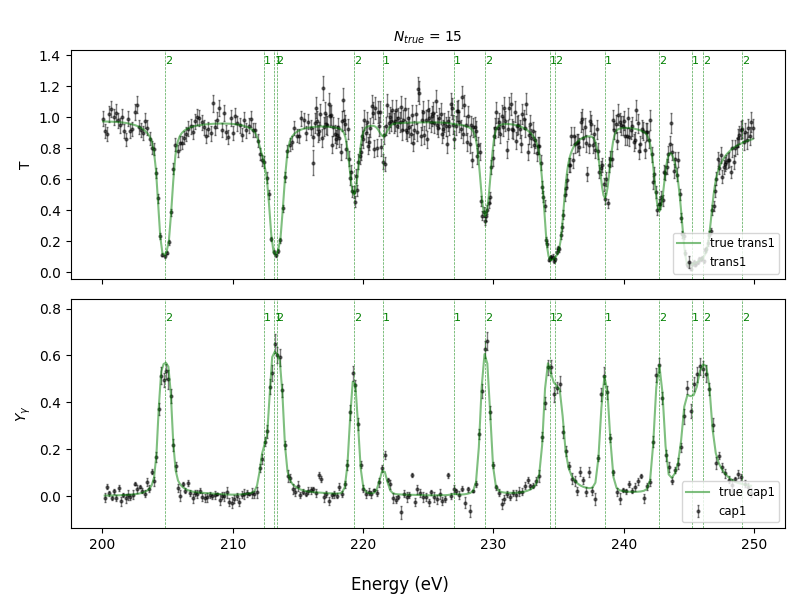

In [6]:
### unpack sample and plot

sample1 = syndat.get_sample(1)

datasets = [sample1['cap1mm'].pw_reduced, sample1['trans1mm'].pw_reduced]#, transdat3, transdat6]
experiments= [cap1mm_exp_gen, trans1mm_exp_gen]#, exptrans3, exptrans6]
covariance_data = [sample1['cap1mm'].covariance_data, sample1['trans1mm'].covariance_data]

fig = plot_datafits(datasets, 
           experiments, 
           fits=[], 
           priors=[], 
           true=datasets, 
           true_pars=Ta_pair.resonance_ladder)
fig.tight_layout()

# saving true
fig.savefig(savefolder+'true.png',  dpi=dpi)

In [7]:
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/home/fire/SAMMY/sammy/build/install/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = InitialFBOPT(Gn_threshold=1e-1,
                       iterations=0)
autofit_initial = InitialFB(options)

In [8]:
outs = autofit_initial.fit(Ta_pair,
                               [200,250],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 124 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.5  : [57.5923, 493.218, 550.8103]
1    0.75 : [22.8425, 62.0418, 84.8843]
2    1.125: [28.4162, 22.1042, 50.5204]
Repeat step 3, 	fudge: ['cap1', 'trans1', 'sum']
		0.225: [35.9195, 30.7781, 66.6976]
		0.045: [21.5488, 14.3623, 35.9111]
3    0.045: [21.5488, 14.3623, 35.9111]
4    0.068: [15.0099, 8.8221, 23.832]
5    0.101: [11.3235, 6.0245, 17.348]
6    0.152: [9.513, 5.2286, 14.7416]
7    0.228: [8.4044, 5.3334, 13.7378]
8    0.342: [7.0531, 5.1897, 12.2428]
9    0.513: [6.8817, 5.0879, 11.9696]
10    0.769: [6.8924, 4.9138, 11.8061]
11    1.153: [6.7569, 4.9026, 11.6595]
12    1.73 : [6.668, 4.8863, 11.5542]
13    2.595: [6.5498, 4.9091, 11.4588]
Chi2 improvement below threshold

----------------------------------------
Eliminated 62.9% of resonance features based on neuton width
Resolving with 46 resonance features
----------------------------------

In [9]:
final_fb_output = outs[-1]
len(final_fb_output.par_post)


40

In [10]:
final_fb_output.pw_post[0]

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,200.176298,-0.007484,0.019445,0.027614,NaN,NaN,NaN,NaN,NaN
1,200.354155,0.040300,0.011665,0.025789,NaN,NaN,NaN,NaN,NaN
2,200.532249,0.013158,0.010475,0.015629,NaN,NaN,NaN,NaN,NaN
3,200.710580,-0.009191,0.009197,0.007389,NaN,NaN,NaN,NaN,NaN
4,200.889150,0.020484,0.010721,0.004296,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
232,248.785641,0.094488,0.016159,0.081700,NaN,NaN,NaN,NaN,NaN
233,249.032087,0.081344,0.012819,0.071589,NaN,NaN,NaN,NaN,NaN
234,249.278900,0.053866,0.014684,0.057243,NaN,NaN,NaN,NaN,NaN
235,249.526080,0.037138,0.017500,0.049835,NaN,NaN,NaN,NaN,NaN


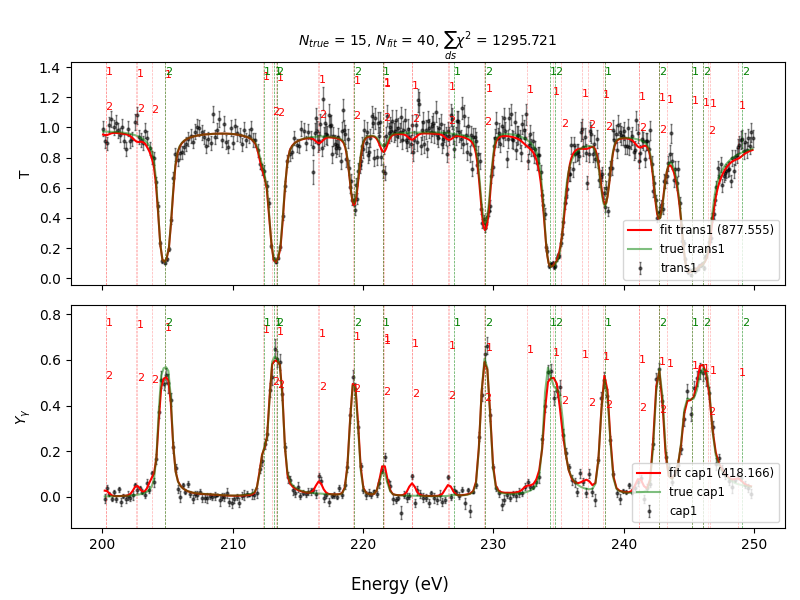

In [11]:
# fig = plot(datasets, experiments, fits=final_fb_output.pw_post, priors=[], true=datasets)
# ax = fig.get_axes()
# # ax[1].plot(final_fb_output.pw_post[0].E,np.flipud(final_fb_output.pw_post[0].theo_xs), 'k')

# # fig.tight_layout()

fig = plot_datafits(datasets, experiments, 
           fits=final_fb_output.pw_post, fits_chi2=final_fb_output.chi2_post,
           priors=[], 
           true=datasets,
true_pars = Ta_pair.resonance_ladder,
fit_pars = final_fb_output.par_post
)
fig.tight_layout()
# saving 
fig.savefig(savefolder+'initial.png', dpi=dpi)

In [12]:
# initial characterization of the fit
init_chars_dict = elim_addit_funcs.characterize_sol(Ta_pair,
                     datasets,
                     experiments,
                     final_fb_output,
                     covariance_data = covariance_data
                     )
print(init_chars_dict)
print(sum(init_chars_dict['chi2_stat']))

Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
{'aic': [658.1659999999999, 1117.5549999999998], 'aicc': [908.5108275862068, 1210.631923076923], 'bic': [1074.3332169362159, 1606.0435273602989], 'bicc': [1416.5583602520871, 1747.3049244926644], 'chi2_stat': [418.166, 877.555], 'NLLW': {'3.0': 79.0807087353554, '4.0': 37.00101206769726}}
1295.721


In [13]:
# Elimination example

import importlib
importlib.reload(chi2_eliminator_v2)
importlib.reload(elim_addit_funcs)

start_ladder = final_fb_output.par_post
assert isinstance(start_ladder, pd.DataFrame)

# side resonances if needed, otherways - keep empty
side_resonances_df = pd.DataFrame()


In [14]:
# # if we do not want to wait hours...

# N = 20

# # just to reduce processing time
# start_ladder = elim_addit_funcs.reduce_ladder(ladder_df=start_ladder,
#                              Gn1_threshold=0.1,
#                              vary_list=[1,1,1],
#                              N=N,
#                              keep_fixed=True,
#                              fixed_side_resonances=side_resonances_df)

# start_ladder

In [15]:

# defining rto & inputs
elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 0,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.05
    )

# defining the elim_opts
elim_opts = chi2_eliminator_v2.elim_OPTs(chi2_allowed = 28,
                                         stop_at_chi2_thr = False,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 20,
                                      deep_fit_step_thr = 0.01,
                                      start_fudge_for_deep_stage = 0.05,
                                      )

In [16]:
elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
                                            sammyINPyw = elim_sammyINPyw , 
                                            options = elim_opts
                            )

In [17]:
# true chi2
true_chars = elimi.evaluate_prior(Ta_pair.resonance_ladder) 
print(true_chars.chi2)

[726.705, 923.862]


In [18]:
hist = elimi.eliminate(ladder_df= start_ladder)# final_fb_output.par_post

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 28


Input ladder:
             E          Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0   200.236284   51.081415    0.144070    1.0     1.0      1.0   1.0
1   202.611598   46.107975    0.210388    1.0     1.0      1.0   1.0
2   204.808973   64.363475   76.293951    1.0     1.0      1.0   1.0
3   212.341997   11.815223    3.142673    1.0     1.0      1.0   1.0
4   213.356652   46.169777   56.833616    1.0     1.0      1.0   1.0
5   216.578789   24.666592    0.223826    1.0     1.0      1.0   1.0
6   219.326684   58.106186   11.947380    1.0     1.0      1.0   1.0
7   221.559970   48.608579    0.285675    1.0     1.0      1.0   1.0
8   221.557688   58.490034    0.131624    1.0     1.0      1.0   1.0
9   223.776780   11.511978    0.468516    1.0     1.0      1.0   1.0
10  226.602771   22.677167    0.406262    1.0     1.0      1.

In [ ]:
# can we save the history not to refit all the time?

case_data = {
        'datasets' : datasets,
        'covariance_data' : covariance_data,
    'experiments': experiments,
    'true_chars': true_chars,
    'Ta_pair': Ta_pair
}

saved_hist = elim_addit_funcs.save_obj_as_pkl(folder_name=savefolder, file_name='hist.pkl', obj=hist)
saved_data = elim_addit_funcs.save_obj_as_pkl(folder_name=savefolder, file_name='dataset.pkl', obj=case_data)



In [ ]:
## Loading data from files to show the history
hist = elim_addit_funcs.load_obj_from_pkl(folder_name=savefolder, pkl_fname='hist.pkl')
case_data_loaded = elim_addit_funcs.load_obj_from_pkl(folder_name=savefolder, pkl_fname='dataset.pkl')
datasets = case_data_loaded['datasets']
covariance_data = case_data_loaded['covariance_data']
experiments = case_data_loaded['experiments']
true_chars = case_data_loaded['true_chars']
Ta_pair = case_data_loaded['Ta_pair']

In [ ]:
true_chars.par

In [ ]:
# just to show how much we aliminated with the given threshold value.
print(f'Eliminated from {hist.ladder_IN.shape[0]} res -> {hist.ladder_OUT.shape[0]}')
print(f'Elim took {np.round(hist.elim_tot_time,2)} sec')


In [ ]:
# images production from history

prior_level = max(hist.elimination_history.keys())
prior_numres = hist.elimination_history[prior_level]['input_ladder'].shape[0]
print(f'Initial ladder, num of res.: {prior_numres}')

min_level_passed_test = prior_level # level - key in the hist..
min_N_res_passed_test = prior_level - 1

levels = []
N_ress = []
chi2_s = []

for level in hist.elimination_history.keys():
        
    numres = hist.elimination_history[level]['selected_ladder_chars'].par_post.shape[0]
    pass_test = hist.elimination_history[level]['final_model_passed_test']

    #print(f'level {level}, # of resonances: {numres},  passed the test: {pass_test}')

    if (pass_test and level<min_level_passed_test):
        min_level_passed_test = level

        min_N_res_passed_test = numres
    
    levels.append(level)
    chi2_s.append(np.sum(hist.elimination_history[level]['selected_ladder_chars'].chi2_post))
    N_ress.append(numres)

# plotting    

# differences in chi2 values between 2 models
chi2_diffs = np.diff(chi2_s, prepend=chi2_s[0]) 

fig, (ax1, ax2) = subplots(2, 1, figsize = fig_size, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# First subplot for the original chi2 values
ax1.plot(N_ress, chi2_s, marker='o')
ax1.axvline(x=min_N_res_passed_test, color='r', linestyle='--')

ax1.set_ylabel('$\chi^2$')
ax1.grid(True)

# changes in chi2

ax2.plot(N_ress, chi2_diffs, marker='o', color='green')
ax2.axvline(x=min_N_res_passed_test, color='r', linestyle='--')
ax2.set_xlabel(r'$N_{res}$')
ax2.set_ylabel('Change in $\chi^2$')
ax2.invert_xaxis()
ax2.grid(True)

tight_layout()
fig.savefig(savefolder+'hist_png', dpi=75)
show()


In [ ]:
# plotting data
def show_plot_from_hist(
        datasets,
        experiments,
        true_chars,
        true_pars,

        level_to_compare: int,
        min_level_passed_test: int,
        elim_hist: dict,
        ):
    
    fits = elim_hist[level_to_compare]['selected_ladder_chars'].pw_post
    fits_chi2 = elim_hist[level_to_compare]['selected_ladder_chars'].chi2_post

    prior_fit = elim_hist[prior_level]['selected_ladder_chars'].pw
    priors_chi2 = elim_hist[prior_level]['selected_ladder_chars'].chi2

    # outfit
    fig = plot_datafits(datasets, experiments, 
        fits=fits, fits_chi2=fits_chi2,
        priors = prior_fit, priors_chi2=priors_chi2,
        true=datasets, true_chi2 = true_chars.chi2,
        true_pars = true_pars,
        fit_pars = elim_hist[level_to_compare]['selected_ladder_chars'].par_post,
        prior_pars = elim_hist[prior_level]['input_ladder'],
        title = f'Fit, Prior & True comparison, model # {level_to_compare}, best selected: {min_level_passed_test}',
        show_spingroups=True
        )
    fig.tight_layout()
    return fig

In [ ]:
# select level num from saved history to compare
# note: always N_res = level-1
N_res_to_view = min_N_res_passed_test
level_to_compare = N_res_to_view+1

fig = show_plot_from_hist(datasets = datasets,
                          experiments=experiments,
                          true_chars = true_chars,
                          true_pars = true_chars.par,
                          level_to_compare=level_to_compare,
                          min_level_passed_test= min_level_passed_test,
                          elim_hist = hist.elimination_history
                          )

In [ ]:
# animation of all steps
images = []

# creating images one by one
for level in hist.elimination_history.keys():

    fig = show_plot_from_hist(datasets = datasets,
                          experiments=experiments,
                          true_chars = true_chars,
                          true_pars = Ta_pair.resonance_ladder,
                          level_to_compare = level,
                          min_level_passed_test = min_level_passed_test,
                          elim_hist = hist.elimination_history
                          )

    img_name = savefolder+'comparison_'+str(level)+'.png' 
    images.append(img_name)
    fig.savefig(img_name, dpi=dpi)

# now create animation from this images
from PIL import Image
import imageio
import glob
import os

folder_path = savefolder
output_name = 'output.gif'

# Define different durations in seconds
start_duration = 3
intermediate_duration = 1.5
end_duration = 5.0

# Convert durations to milliseconds (as required by imageio)
start_duration_ms = start_duration * 1000
intermediate_duration_ms = intermediate_duration * 1000
end_duration_ms = end_duration * 1000

# Additional images to be added
additional_start_images = [savefolder+'true.png',
                           savefolder+'initial.png']  

additional_end_images = [savefolder+'hist_png.png']

# Combine all images in the required order
all_images = additional_start_images + images + additional_end_images


# Check and print the size of each image
for img_path in all_images:
    with Image.open(img_path) as img:
        print(f"{os.path.basename(img_path)} - Size: {img.size}")

# Create a list of images from the combined file list
images = [Image.open(f) for f in all_images]

# Output path for the animated GIF
output_path = os.path.join(folder_path, output_name)

# Create a list of durations corresponding to each image
durations = ([start_duration_ms] * len(additional_start_images) + 
             [intermediate_duration_ms] * len(images) + 
             [end_duration_ms] * len(additional_end_images))

# Save the animated GIF using imageio
imageio.mimsave(output_path, images, duration=durations) 

print(f"Animated GIF saved to {output_path}")

In [ ]:
# table for analysis of the models - produce chi2

# sums - for all datasets
NLLW_s = []
chi2_s = []
aicc_s = []
bicc_s = []
N_res_s = []
test_pass = []

for level in hist.elimination_history.keys():
        
    numres = hist.elimination_history[level]['selected_ladder_chars'].par_post.shape[0]
    pass_test = hist.elimination_history[level]['final_model_passed_test']

    # print(f'level {level}, # of resonances: {numres},  passed the test: {pass_test}')
    cur_ch_dict = elim_addit_funcs.characterize_sol(Ta_pair=Ta_pair,
                     datasets=datasets,
                     experiments=experiments,
                     sol = hist.elimination_history[level]['selected_ladder_chars'],
                     covariance_data = covariance_data
                     )
    
    N_res_s.append(numres)
    test_pass.append(pass_test)
    chi2_s.append(sum(cur_ch_dict['chi2_stat']))
    aicc_s.append(sum(cur_ch_dict['aicc']))
    bicc_s.append(sum(cur_ch_dict['bicc']))
    NLLW_s.append(sum(cur_ch_dict['NLLW'].values()))


    # levels.append(level)
    # chi2_s.append(np.sum(hist.elimination_history[level]['selected_ladder_chars'].chi2_post))
    # N_ress.append(numres)
    print(cur_ch_dict )

# combine to one DataFrame
table_df = pd.DataFrame.from_dict({
    'N_res': N_res_s,
    'passed': test_pass,
    'sum_chi2': chi2_s,
    'sum_NLLW': NLLW_s,
    'sum_AICc': aicc_s,
    'sum_BICc': bicc_s

})
table_df

In [ ]:
# save table
table_df.to_csv(path_or_buf=savefolder+'models_comparison_table.csv')

In [ ]:
# compare 2 models plot..
# which space?

model1 = hist.elimination_history[18]['selected_ladder_chars']

model2 = hist.elimination_history[17]['selected_ladder_chars']

fig = plot_datafits(datasets, experiments, 
    fits=model1.pw_post, fits_chi2=model1.chi2_post, f_model_name='model1',
    priors=model2.pw_post, priors_chi2=model2.chi2_post, pr_model_name='model2',

     true=datasets, true_chi2 = true_chars.chi2, t_model_name ='true',
        true_pars = Ta_pair.resonance_ladder,
        fit_pars = model1.par_post,
        prior_pars = model2.par,
      
    title = 'Models Comparison',
    show_spingroups = False,
    fig_size = fig_size
    )

In [ ]:
# TODO: analyze logic & funcs on found/not found, missed spin_groups, calc error on the fine grid.